## Objectives

## Code Implementation

In [1]:
import pandas as pd
cities = pd.read_csv('../data/cleaned_data/apta_cities_cleaned.csv')
cities = cities.drop(columns=['Unnamed: 0'])
cities.head()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


,City,Population,Area,Cost_per_trip,Fare_per_trip,Miles_per_trip
0,"Seattle--Tacoma, WA",3544011,982.52,13.906032,1.570667,5.786344
1,"Spokane, WA",447279,171.67,13.433827,0.988308,4.772569
2,"Yakima, WA",133145,55.77,19.720093,1.112531,5.179168
3,"Eugene, OR",270179,73.49,10.851494,2.753356,3.684118
4,"Portland, OR--WA",2104238,519.30,10.804361,1.025659,4.011388


In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples, silhouette_score

X = cities.drop(columns=['City']).to_numpy()

print('NUMERIC MEAN:\n',np.mean(X,axis=0))
print("X SHAPE",X.shape)
print("NUMERIC COV:")
print(np.cov(X.T))

from numpy import linalg as LA
w, v1 = LA.eig(np.cov(X.T))
print("\nCOV EIGENVALUES:",w)
print("COV EIGENVECTORS (across rows):")
print(v1.T)

NUMERIC MEAN:
 [7.63817374e+05 2.54954371e+02 1.62164796e+01 1.69764181e+00
 6.02033451e+00]
X SHAPE (286, 5)
NUMERIC COV:
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
[[ 3.00348049e+12  6.21976504e+08 -2.68509287e+06 -2.80714130e+05
  -3.74964286e+05]
 [ 6.21976504e+08  1.60662563e+05 -7.09356971e+02 -8.34065149e+01
  -1.18548286e+02]
 [-2.68509287e+06 -7.09356971e+02  1.12521769e+02  1.14344019e+01
   1.54309551e+01]
 [-2.80714130e+05 -8.34065149e+01  1.14344019e+01  1.07182685e+01
   6.17463373e+00]
 [-3.74964286e+05 -1.18548286e+02  1.54309551e+01  6.17463373e+00
   2.61947556e+01]]
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advance

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/var/folders/z5/l6g0391s0qg3vsbnvl7y81n80000gn/T/ipykernel_36075/3215643524.py:17: MatplotlibDeprecationWarning: Passing the emit parameter of set_xlim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  plt.xlim(1, 5, 1)


(1.0, 5.0)

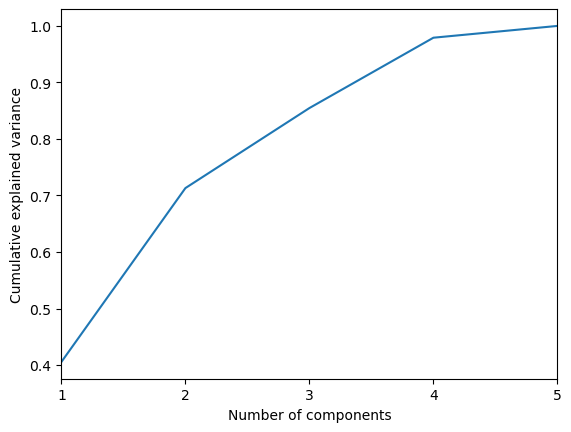

In [3]:
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(X)
cov = (X.T @ X) / (X.shape[0] - 1)
w, v1 = np.linalg.eig(cov)

idx = np.argsort(w, axis=0)[::-1]
sorted_eig_vectors = v1[:, idx]

cumsum = np.cumsum(w[idx]) / np.sum(w[idx])
xint = range(1, len(cumsum) + 1)
plt.plot(xint, cumsum)

plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.xticks(xint)
plt.xlim(1, 5, 1)

<Axes: >

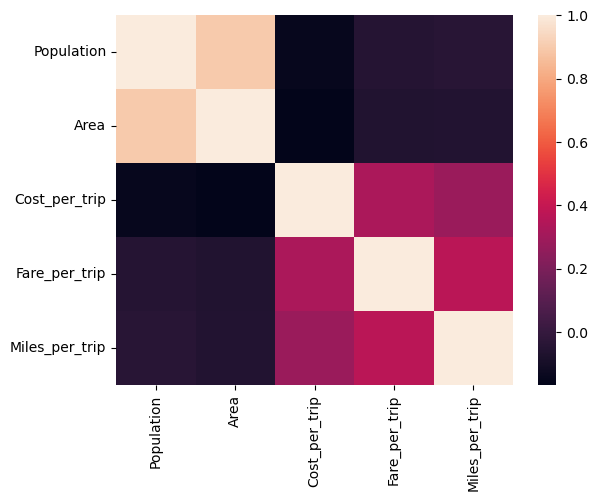

In [4]:
import seaborn as sns
X_df = pd.DataFrame(X).rename(columns={0: 'Population', 1: 'Area', 2: 'Cost_per_trip', 3: 'Fare_per_trip', 4: 'Miles_per_trip'})
sns.heatmap(X_df.corr())

In [5]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
pca.fit(X)
data_pca = pca.transform(X)
data_pca = pd.DataFrame(data_pca,columns=['PC1','PC2','PC3','PC4'])
data_pca.head()

,PC1,PC2,PC3,PC4
0,2.195331,1.041785,-0.110497,-0.016923
1,-0.031348,-0.494236,0.066595,0.048293
2,-0.552852,-0.343962,-0.319175,-0.122077
3,-0.252383,-0.531766,0.230998,0.663955
4,1.206063,-0.041013,0.042951,0.169983


<Axes: >

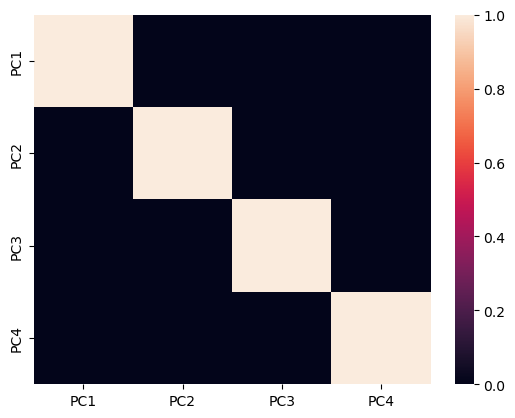

In [6]:
sns.heatmap(data_pca.corr())

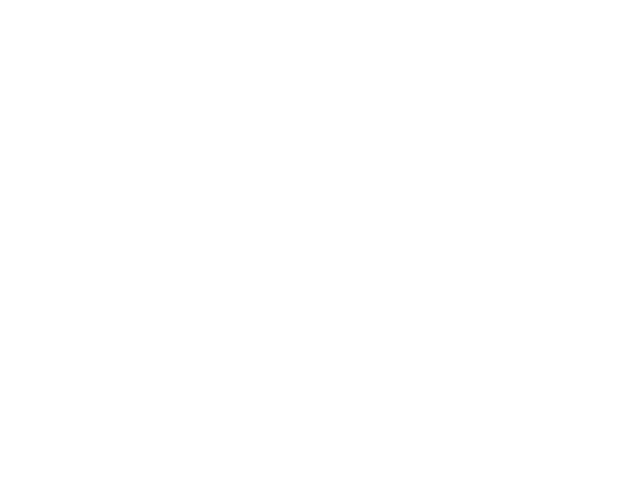

In [16]:

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(data_pca['PC2'],data_pca['PC3'],data_pca['PC4'], c=data_pca['PC1'])
ax.set_title("3D Plot of Principal Components")
ax.set_xlabel('PC2')
ax.set_ylabel('PC3')
ax.set_zlabel('PC4')
plt.show()

RESULTS
shape :  (286, 3)
First few points : 
 [[ -9.726924   -16.770332   -11.739644  ]
 [  1.2530551  -14.637746    -0.95117176]
 [ 28.71916      1.3856144   -0.31036332]
 [  5.873687     4.3193254   21.88686   ]]


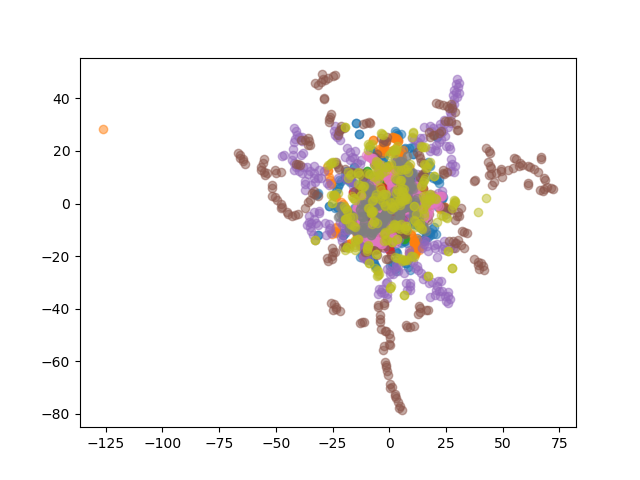

In [26]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=3, learning_rate='auto',init='random', perplexity=1).fit_transform(X)

# EXPLORE RESULTS
print("RESULTS") 
print("shape : ",X_embedded.shape)
print("First few points : \n",X_embedded[0:4,:])

# PLOT 
plt.scatter(X_embedded[:,0],X_embedded[:,1], alpha=0.5)
plt.show()

RESULTS
shape :  (286, 3)
First few points : 
 [[ 10.331259  -10.506528  -11.510693 ]
 [ -6.15948    -1.0071286   2.6866064]
 [  1.8365389   5.3667107  10.372743 ]
 [-12.317913   -8.945713    2.5623868]]


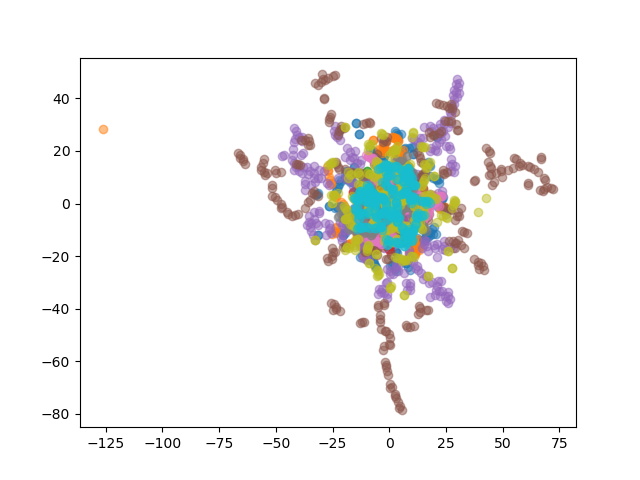

In [27]:
X_embedded = TSNE(n_components=3, learning_rate='auto',init='random', perplexity=4).fit_transform(X)

# EXPLORE RESULTS
print("RESULTS") 
print("shape : ",X_embedded.shape)
print("First few points : \n",X_embedded[0:4,:])

# PLOT 
plt.scatter(X_embedded[:,0],X_embedded[:,1], alpha=0.5)
plt.show()

## Reporting